<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="Rossum"></p>

<h1 style="text-align: center;">Deep Learning<br><br>Session - 8<br><br>Image Classification with CNN<br><br>Cat-Dog Classification Project Solution<br><h1>

# Dataset Info

The Dogs vs. Cats dataset is a common computer vision dataset in which pictures are classified as either including a dog or a cat.

After the dataset is well studied, it can be used to understand and practice how to design, evaluate, and apply convolutional neural networks for image classification.

You will build a classifier with images and try to detect dogs versus cats using CNN.

Train set includes 12500 cat-5026 dog images, validation set includes 1219 cat-1071 dog images and test set incgludes 6897 cat and dogs images together. 

# Import Libraries and Export Images from Zip_File

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

#import warnings
#warnings.filterwarnings("ignore")
#warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [11]:
import tensorflow as tf

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import zipfile

# Unzip the file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/DL/cat_dog_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

# Recognizing and Understanding Data

In [14]:
my_data_dir = 'data'

In [15]:
os.listdir(my_data_dir)

['test', 'train', 'validation']

In [16]:
val_path = my_data_dir+'/validation/'
train_path = my_data_dir+'/train/'
test_path = my_data_dir+'/test/'

In [17]:
os.listdir(train_path)

['cat', 'dog']

In [18]:
os.listdir(val_path)

['cat', 'dog']

In [19]:
os.listdir(test_path)[:5]

['5355.jpg', '6248.jpg', '11778.jpg', '5760.jpg', '11192.jpg']

In [20]:
# Alternative method
import pathlib

data_dir = pathlib.Path(train_path) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['cat' 'dog']


**Let's check how many images there are.**

In [21]:
len(os.listdir(train_path+'cat')), len(os.listdir(train_path+'dog'))

(12500, 5026)

In [22]:
len(os.listdir(val_path+'cat')), len(os.listdir(val_path+'dog'))

(1219, 1071)

In [23]:
# Walk through cell_images directory and list number of files
for dirpath, dirnames, filenames in os.walk(my_data_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'data'.
There are 0 directories and 6897 images in 'data/test'.
There are 2 directories and 0 images in 'data/train'.
There are 0 directories and 12500 images in 'data/train/cat'.
There are 0 directories and 5026 images in 'data/train/dog'.
There are 2 directories and 0 images in 'data/validation'.
There are 0 directories and 1219 images in 'data/validation/cat'.
There are 0 directories and 1071 images in 'data/validation/dog'.


**Let's take an example images from both train-cat and train-dog folders to observe process** 

In [24]:
os.listdir(train_path+'cat')[0]


'cat.12181.jpg'

In [25]:
os.listdir(train_path+'dog')[0]


'dog.11798.jpg'

In [26]:
path1=train_path+'cat'+'/cat.4593.jpg'
path2=train_path+'dog'+'/dog.10086.jpg'

In [27]:
cat_img=imread(path1)
dog_img=imread(path2)

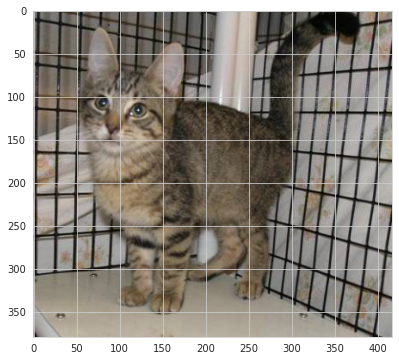

In [28]:
plt.imshow(cat_img)  

CNN'de boyutlar ayni olmali!!!

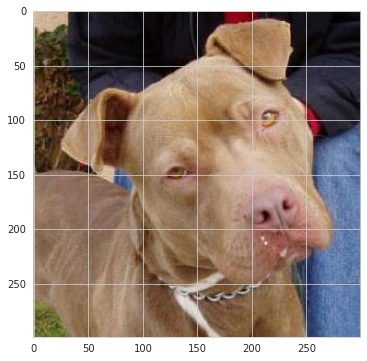

In [29]:
plt.imshow(dog_img)

In [30]:
# View an image
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (291, 389, 3)


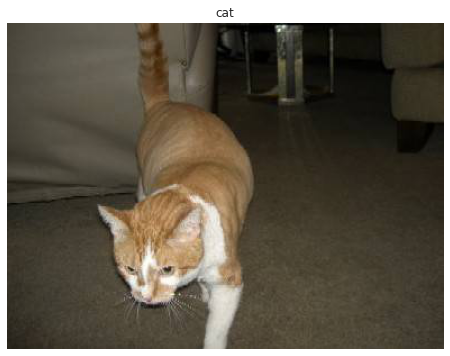

In [31]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path,
                        target_class="cat")

Image shape: (500, 415, 3)


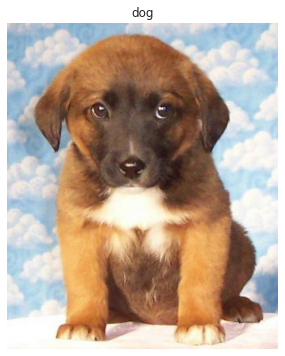

In [32]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_path,
                        target_class="dog")

Image shape: (198, 200, 3)


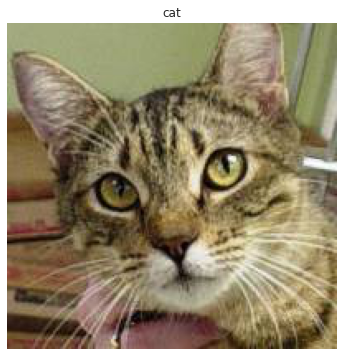

In [33]:
# View a random image from the training dataset
import random
img = view_random_image(target_dir=train_path,
                        target_class=random.choice(class_names)) # get a random class name

# Data Preprocessing

## Defining Input Shape

**Let's decide on the final dimension of these images.**

In [34]:
cat_img.shape

(379, 417, 3)

In [35]:
dog_img.shape

(299, 300, 3)

In [36]:
x = [imread(train_path+'cat/'+image).shape[0] for image in os.listdir(train_path+'cat')]
y = [imread(train_path+'cat/'+image).shape[1] for image in os.listdir(train_path+'cat')]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


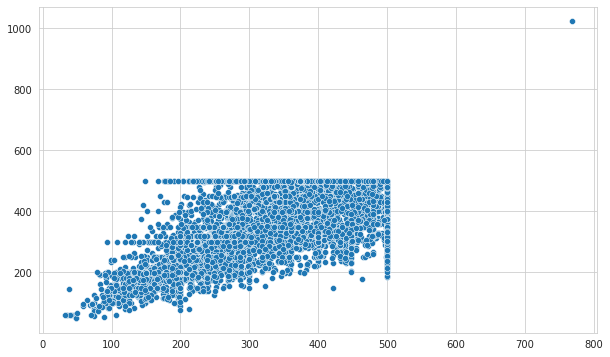

In [37]:
sns.scatterplot(x,y);

In [38]:
np.mean(x), np.median(x)

(356.46712, 374.0)

In [39]:
np.mean(y), np.median(y)

(410.52264, 470.0)

In [40]:
image_shape = (128,128,3)

## Scalling

**Let's check the images if they are needed to be scaled or not**

In [41]:
cat_img.max()

255

In [42]:
cat_img.min()

0

As we see above, images need to be scaled

## Image Data Generator

**Image Manipulation**

We can use the ImageDataGenerator to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. ImageDataGenerator does the followings.

* Accepts a batch of images used for training.
* Applies a series of random transformations to each image in the batch.
* Replaces the original batch with randomly transformed batch.
* Training the CNN on this randomly transformed batch.

The goal of applying data augmentation is to have a more generalized model.

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [44]:
# help(ImageDataGenerator)

In [45]:
image_gen = ImageDataGenerator(rotation_range=15, # rotate the image 15 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [ ]:
#image_gen2 = ImageDataGenerator(rescale=1/255, # Rescale the image by normalzing it.)

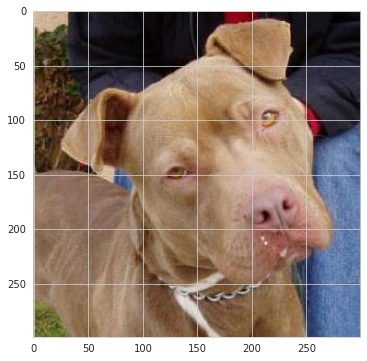

In [46]:
plt.imshow(dog_img);

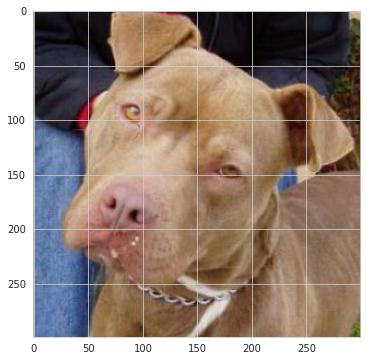

In [47]:
plt.imshow(image_gen.random_transform(dog_img));

### Taking the path to a directory & Generating batches of augmented data

flow_from_directory function works with images organized in sub-directories. Your directories should include only one class of images, so one folder per class of images.

In [48]:
#help(image_gen.flow_from_directory)
#Takes the path to a directory & generates batches of augmented data.

In [49]:
image_gen.flow_from_directory(train_path)

Found 17526 images belonging to 2 classes.


In [50]:
image_gen.flow_from_directory(val_path)

Found 2290 images belonging to 2 classes.


In [51]:
image_gen.flow_from_directory(test_path)

Found 0 images belonging to 0 classes.


In [52]:
batch_size = 32

In [53]:
train_image_gen = image_gen.flow_from_directory(directory=train_path,
                                                target_size=image_shape[:2],
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                class_mode='binary',
                                                shuffle=True)

Found 17526 images belonging to 2 classes.


In [54]:
val_image_gen = image_gen.flow_from_directory(directory=val_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=False)

Found 2290 images belonging to 2 classes.


In [55]:
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [56]:
train_image_gen[0][0].shape

(32, 128, 128, 3)

In [57]:
len(train_image_gen), len(val_image_gen)

(548, 72)

In [58]:
len(train_image_gen)*batch_size, len(val_image_gen)*batch_size 

(17536, 2304)

In [59]:
# Get a sample of the training data batch 
images, labels = train_image_gen.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [60]:
# Get a sample of the testing data batch 
images, labels = val_image_gen.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

# Modelling-1

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
model1 = Sequential()

model1.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(128))
model1.add(Activation('relu'))

model1.add(Dense(64))
model1.add(Activation('relu'))

model1.add(Dense(1))
model1.add(Activation('sigmoid'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [63]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [119]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights = True)

In [120]:
model1.fit(train_image_gen,
          epochs=10,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

Epoch 1/10
548/548 [==============================] - 109s 199ms/step - loss: 0.2958 - accuracy: 0.8745 - val_loss: 0.4669 - val_accuracy: 0.7882
Epoch 2/10
548/548 [==============================] - 109s 198ms/step - loss: 0.2868 - accuracy: 0.8778 - val_loss: 0.3466 - val_accuracy: 0.8524
Epoch 3/10
548/548 [==============================] - 110s 200ms/step - loss: 0.2752 - accuracy: 0.8810 - val_loss: 0.3456 - val_accuracy: 0.8459
Epoch 4/10
548/548 [==============================] - 110s 201ms/step - loss: 0.2622 - accuracy: 0.8879 - val_loss: 0.5493 - val_accuracy: 0.7865
Epoch 5/10
548/548 [==============================] - 111s 203ms/step - loss: 0.2483 - accuracy: 0.8939 - val_loss: 0.3569 - val_accuracy: 0.8441


In [121]:
summary = pd.DataFrame(model1.history.history)

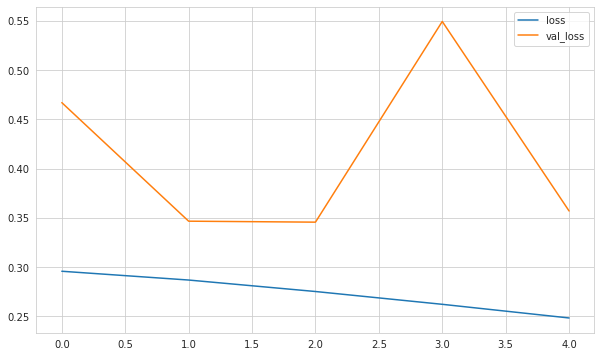

In [122]:
summary[["loss", "val_loss"]].plot();

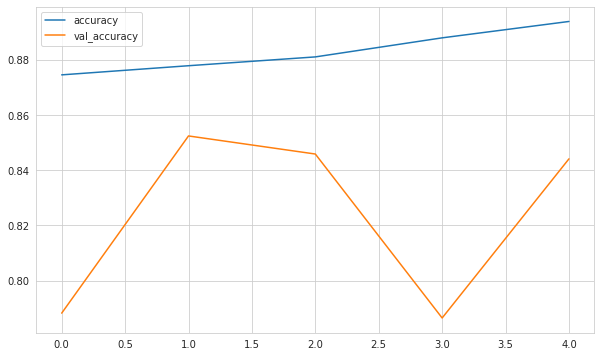

In [123]:
summary[["accuracy", "val_accuracy"]].plot();

# Modelling-2

In [69]:
model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())

model2.add(Dense(128))
model2.add(Activation('relu'))

model2.add(Dense(128))
model2.add(Activation('relu'))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [70]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 32)       128       
 hNormalization)                                                 
                                                      

In [71]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [72]:
model2.fit(train_image_gen,
          epochs=15,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

Epoch 1/15
548/548 [==============================] - 111s 201ms/step - loss: 0.5440 - accuracy: 0.7450 - val_loss: 1.2098 - val_accuracy: 0.5659
Epoch 2/15
548/548 [==============================] - 110s 201ms/step - loss: 0.4483 - accuracy: 0.7929 - val_loss: 0.8654 - val_accuracy: 0.6175
Epoch 3/15
548/548 [==============================] - 111s 202ms/step - loss: 0.3782 - accuracy: 0.8313 - val_loss: 0.4702 - val_accuracy: 0.7843
Epoch 4/15
548/548 [==============================] - 110s 201ms/step - loss: 0.3263 - accuracy: 0.8596 - val_loss: 1.2489 - val_accuracy: 0.6052
Epoch 5/15
548/548 [==============================] - 110s 201ms/step - loss: 0.2891 - accuracy: 0.8781 - val_loss: 0.8036 - val_accuracy: 0.6969
Epoch 6/15
548/548 [==============================] - 110s 201ms/step - loss: 0.2700 - accuracy: 0.8850 - val_loss: 0.3569 - val_accuracy: 0.8371
Epoch 7/15
548/548 [==============================] - 110s 201ms/step - loss: 0.2459 - accuracy: 0.8967 - val_loss: 0.3793 -

In [73]:
summary = pd.DataFrame(model2.history.history)

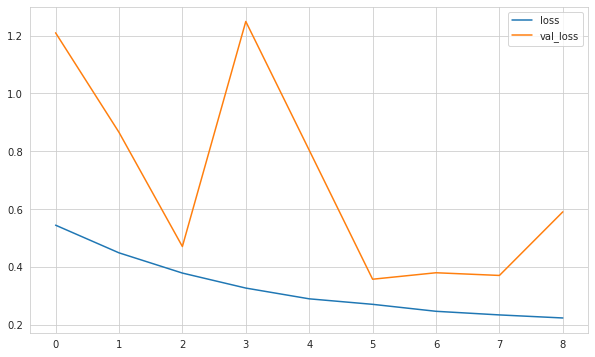

In [74]:
summary[["loss", "val_loss"]].plot();

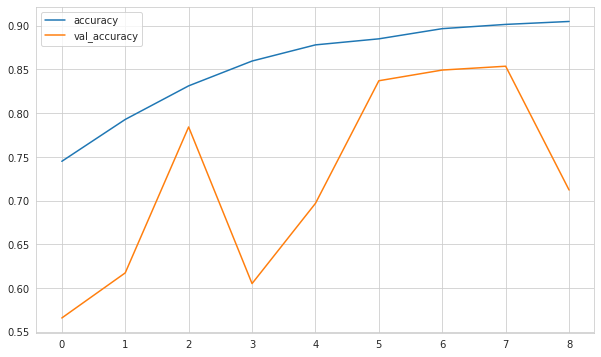

In [75]:
summary[["accuracy", "val_accuracy"]].plot();

# Modelling-3

In [76]:
model3 = Sequential()

model3.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=image_shape, activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())

model3.add(Dense(128))
model3.add(Activation('relu'))

model3.add(Dense(128))
model3.add(Activation('relu'))

model3.add(Dense(1))
model3.add(Activation('sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [77]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_4 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      2320      
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                      

In [78]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True)

In [79]:
model3.fit(train_image_gen,
          epochs=20,
          steps_per_epoch=len(train_image_gen),
          validation_data=val_image_gen,
          validation_steps=len(val_image_gen),
          callbacks=[early_stop])

Epoch 1/20
548/548 [==============================] - 119s 214ms/step - loss: 0.5805 - accuracy: 0.7316 - val_loss: 0.6554 - val_accuracy: 0.6572
Epoch 2/20
548/548 [==============================] - 116s 212ms/step - loss: 0.4550 - accuracy: 0.7895 - val_loss: 0.6098 - val_accuracy: 0.7358
Epoch 3/20
548/548 [==============================] - 116s 212ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.5601 - val_accuracy: 0.7598
Epoch 4/20
548/548 [==============================] - 118s 215ms/step - loss: 0.3347 - accuracy: 0.8507 - val_loss: 0.4959 - val_accuracy: 0.7424
Epoch 5/20
548/548 [==============================] - 116s 213ms/step - loss: 0.2870 - accuracy: 0.8751 - val_loss: 0.5305 - val_accuracy: 0.7655
Epoch 6/20
548/548 [==============================] - 115s 211ms/step - loss: 0.2461 - accuracy: 0.8983 - val_loss: 0.4624 - val_accuracy: 0.8044
Epoch 7/20
548/548 [==============================] - 116s 211ms/step - loss: 0.2175 - accuracy: 0.9083 - val_loss: 0.2813 -

In [ ]:
# model3.save('cat_dog_detector.h5')

In [80]:
summary = pd.DataFrame(model3.history.history)

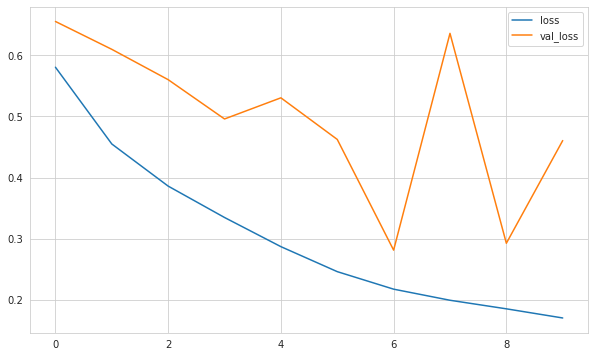

In [81]:
summary[["loss", "val_loss"]].plot();

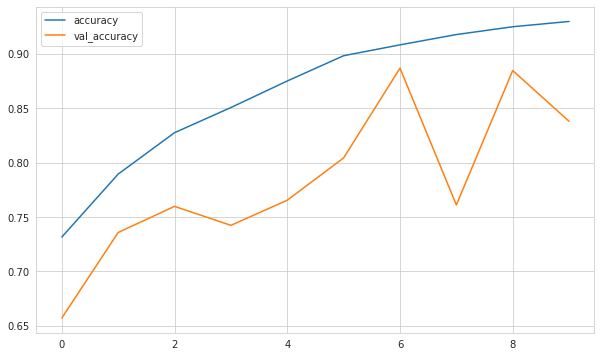

In [82]:
summary[["accuracy", "val_accuracy"]].plot();

# Evaluation on Test Data

In [83]:
from sklearn.metrics import classification_report, confusion_matrix

In [84]:
score = model3.evaluate(val_image_gen)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

72/72 [==============================] - 13s 174ms/step - loss: 0.2749 - accuracy: 0.8900
Test loss: 0.27493420243263245
Test accuracy: 0.8899563550949097


In [85]:
pred_prob = model3.predict(val_image_gen)
pred_prob

array([[1.4077983e-06],
       [4.1651696e-01],
       [2.6966689e-02],
       ...,
       [9.2481977e-01],
       [9.5637316e-01],
       [9.2197037e-01]], dtype=float32)

In [86]:
y_pred = pred_prob > 0.5
y_pred

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [87]:
y_test = val_image_gen.classes

In [88]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      1219
           1       0.91      0.83      0.87      1071

    accuracy                           0.88      2290
   macro avg       0.89      0.88      0.88      2290
weighted avg       0.89      0.88      0.88      2290



In [89]:
confusion_matrix(y_test, y_pred)

array([[1134,   85],
       [ 182,  889]])

In [90]:
model3.save('cat_dog_detector.h5')

# Prediction-1

In [91]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [92]:
model=load_model('cat_dog_detector.h5')

In [93]:
img_path = "/content/data/test/10005.jpg"

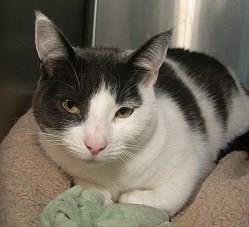

In [94]:
img=image.load_img(img_path)
img

In [95]:
img = np.array(img)  # resize icin img'a cevirmis olmam lazim

In [96]:
img.shape

(227, 249, 3)

In [97]:
resized_img = image.smart_resize(img, (128, 128)) # img has to be numpy array 
resized_img.shape

#resized_img = img.resize((128, 128)) # img has to be image format (like jpg, png etc)
#resized_img

(128, 128, 3)

In [98]:
resized_img.max()

254.4644

In [99]:
resized_img = resized_img / 255

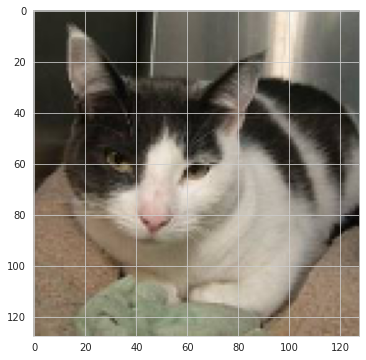

In [100]:
plt.imshow(resized_img)

In [101]:
resized_img=np.expand_dims(resized_img, axis=0)
resized_img.shape

(1, 128, 128, 3)

In [102]:
model.predict(resized_img)

array([[0.00025384]], dtype=float32)

In [103]:
val_image_gen.class_indices

{'cat': 0, 'dog': 1}

# Prediction-2

In [104]:
random_image = random.sample(os.listdir(test_path), 1)
random_image

['5250.jpg']

In [105]:
image_path = test_path + "/" + random_image[0]
image_path

'data/test//5250.jpg'

In [106]:
my_image = image.load_img(image_path, target_size=image_shape)

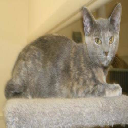

In [107]:
my_image

In [108]:
type(my_image)

PIL.Image.Image

In [109]:
#my_image = np.array(my_image)
my_image = image.img_to_array(my_image)

In [110]:
my_image.max()

243.0

In [111]:
my_image = my_image / 255

In [112]:
my_image.shape

(128, 128, 3)

In [113]:
my_image = np.expand_dims(my_image, axis=0)

In [114]:
my_image.shape

(1, 128, 128, 3)

In [115]:
model.predict(my_image)

array([[0.00018071]], dtype=float32)

In [116]:
train_image_gen.class_indices

{'cat': 0, 'dog': 1}

In [117]:
def pred_and_plot(model, img_size):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    random_image = random.sample(os.listdir(test_path), 1)
    img_path = test_path + "/" + random_image[0]
    img = image.load_img(img_path, target_size=img_size)
    img = np.array(img)
    if img.max() > 1:
        img = img/255
  
    # Make a prediction
    pred = model.predict(np.expand_dims(img, axis=0))
    print("prediction_probability: ", pred.max())

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
        pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

prediction_probability:  0.011056863


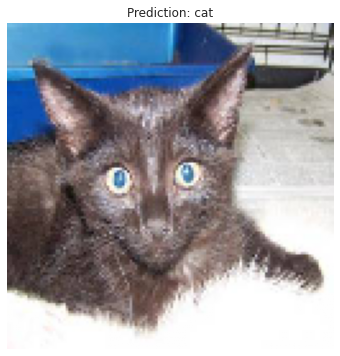

In [135]:
pred_and_plot(model, image_shape[:2])

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="Rossum"></p>